In [2]:
!choco install visualcpp-build-tools

^C


In [3]:
pip install --upgrade pip setuptools wheel

# HTTPS://ONA-BOOK.ORG
#Handbook of Graphs and Networks in People Analytics: With Examples in R and Python


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade gensim


  Using cached gensim-4.3.2.tar.gz (23.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached scipy-1.14.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached smart_open-7.0.4-py3-none-any.whl.metadata (23 kB)
  Using cached wrapt-1.16.0-cp312-cp312-win_amd64.whl.metadata (6.8 kB)
Using cached scipy-1.14.0-cp312-cp312-win_amd64.whl (44.5 MB)
Using cached smart_open-7.0.4-py3-none-any.whl (61 kB)
Using cached wrapt-1.16.0-cp312-cp312-win_amd64.whl (37 kB)
  Created wheel for gensim: filename=gensim-4.3.2-cp312-cp312-win_amd64.whl size=23929533 sha256=d0d6776c2765e579e28c69cee65622086a55c94cac41bc596fdef6bc827a9cd1
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\50\c0\ac\7b

In [2]:
pip install scipy==1.12

  Using cached scipy-1.12.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.12.0-cp312-cp312-win_amd64.whl (45.8 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.0
    Uninstalling scipy-1.14.0:
      Successfully uninstalled scipy-1.14.0
Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install azure-storage-file-datalake pandas pyarrow openpyxl xlrd networkx matplotlib  


Note: you may need to restart the kernel to use updated packages.


In [68]:
parquet_file_path = "combined_data.parquet"

df = pd.read_parquet(parquet_file_path, engine='pyarrow')
empty_card_check_no_df = df[df['Card_Check_No'].isna() | (df['Card_Check_No'] == '')]

# Print the filtered DataFrame
print(len(empty_card_check_no_df))
df['Card_Check_No'].tail(10)


0


145956    434256******9735
145957    440393******8485
145958    511015******7389
145959    434769******2633
145960    440393******8485
145961    424631******1591
145962    434256******3811
145963    440393******8485
145964    436618******5452
145965    424631******1591
Name: Card_Check_No, dtype: object

In [69]:
df.to_csv('combined_data.csv', index=False)

In [8]:
import pandas as pd
import numpy as np


parquet_file_path = "combined_data.parquet"
data = pd.read_parquet(parquet_file_path, engine='pyarrow')
data['Amount'] = data['Amount'].astype(float)


# Node DataFrames
data.dropna(subset=['Card_Check_No','Trans_Type','Card_Check_Type'], inplace=True)
data= data[data['Card_Check_No'].str.contains('^[0-9]')]

customer_nodes = data[['Card_Check_No']].drop_duplicates().reset_index(drop=True)
customer_nodes['Node_Type'] = 'Customer'

# Unique transaction types
transaction_type_nodes = data[['Trans_Type']].drop_duplicates().reset_index(drop=True)
transaction_type_nodes['Node_Type'] = 'Transaction_Type'


# Node DataFrame
nodes = pd.concat([customer_nodes, 
                   transaction_type_nodes.rename(columns={'Trans_Type': 'Card_Check_No'})],
                  ignore_index=True)

# Edge DataFrames
# Customer-Transaction Type Edges
customer_transaction_edges = data.groupby(['Card_Check_No', 'Trans_Type']).agg(
    Frequency=('Trans_Type', 'size'),
    Total_Amount=('Amount', 'sum'),
    Average_Amount=('Amount', 'mean')
).reset_index()
customer_transaction_edges['Edge_Type'] = 'Customer-Transaction_Type'


# Edge DataFrame
edges = pd.concat([customer_transaction_edges], ignore_index=True)

edges = edges[edges['Trans_Type'].isna()==False]
len(edges)
#edges = edges[edges['Card_Check_Type'].isna()==False]
edges





,Card_Check_No,Trans_Type,Frequency,Total_Amount,Average_Amount,Edge_Type
0,000397,Check,1,100.0,100.000000,Customer-Transaction_Type
1,000478,Check,1,400.0,400.000000,Customer-Transaction_Type
2,00141,Check,1,300.0,300.000000,Customer-Transaction_Type
3,00143,Check,1,300.0,300.000000,Customer-Transaction_Type
4,001463,Check,1,100.0,100.000000,Customer-Transaction_Type
...,...,...,...,...,...,...
54295,998939,Check,1,2000.0,2000.000000,Customer-Transaction_Type
54296,999538,Check,1,1000.0,1000.000000,Customer-Transaction_Type
54297,999591,Check,1,1000.0,1000.000000,Customer-Transaction_Type
54298,999994******9181,Credit,1,200.0,200.000000,Customer-Transaction_Type


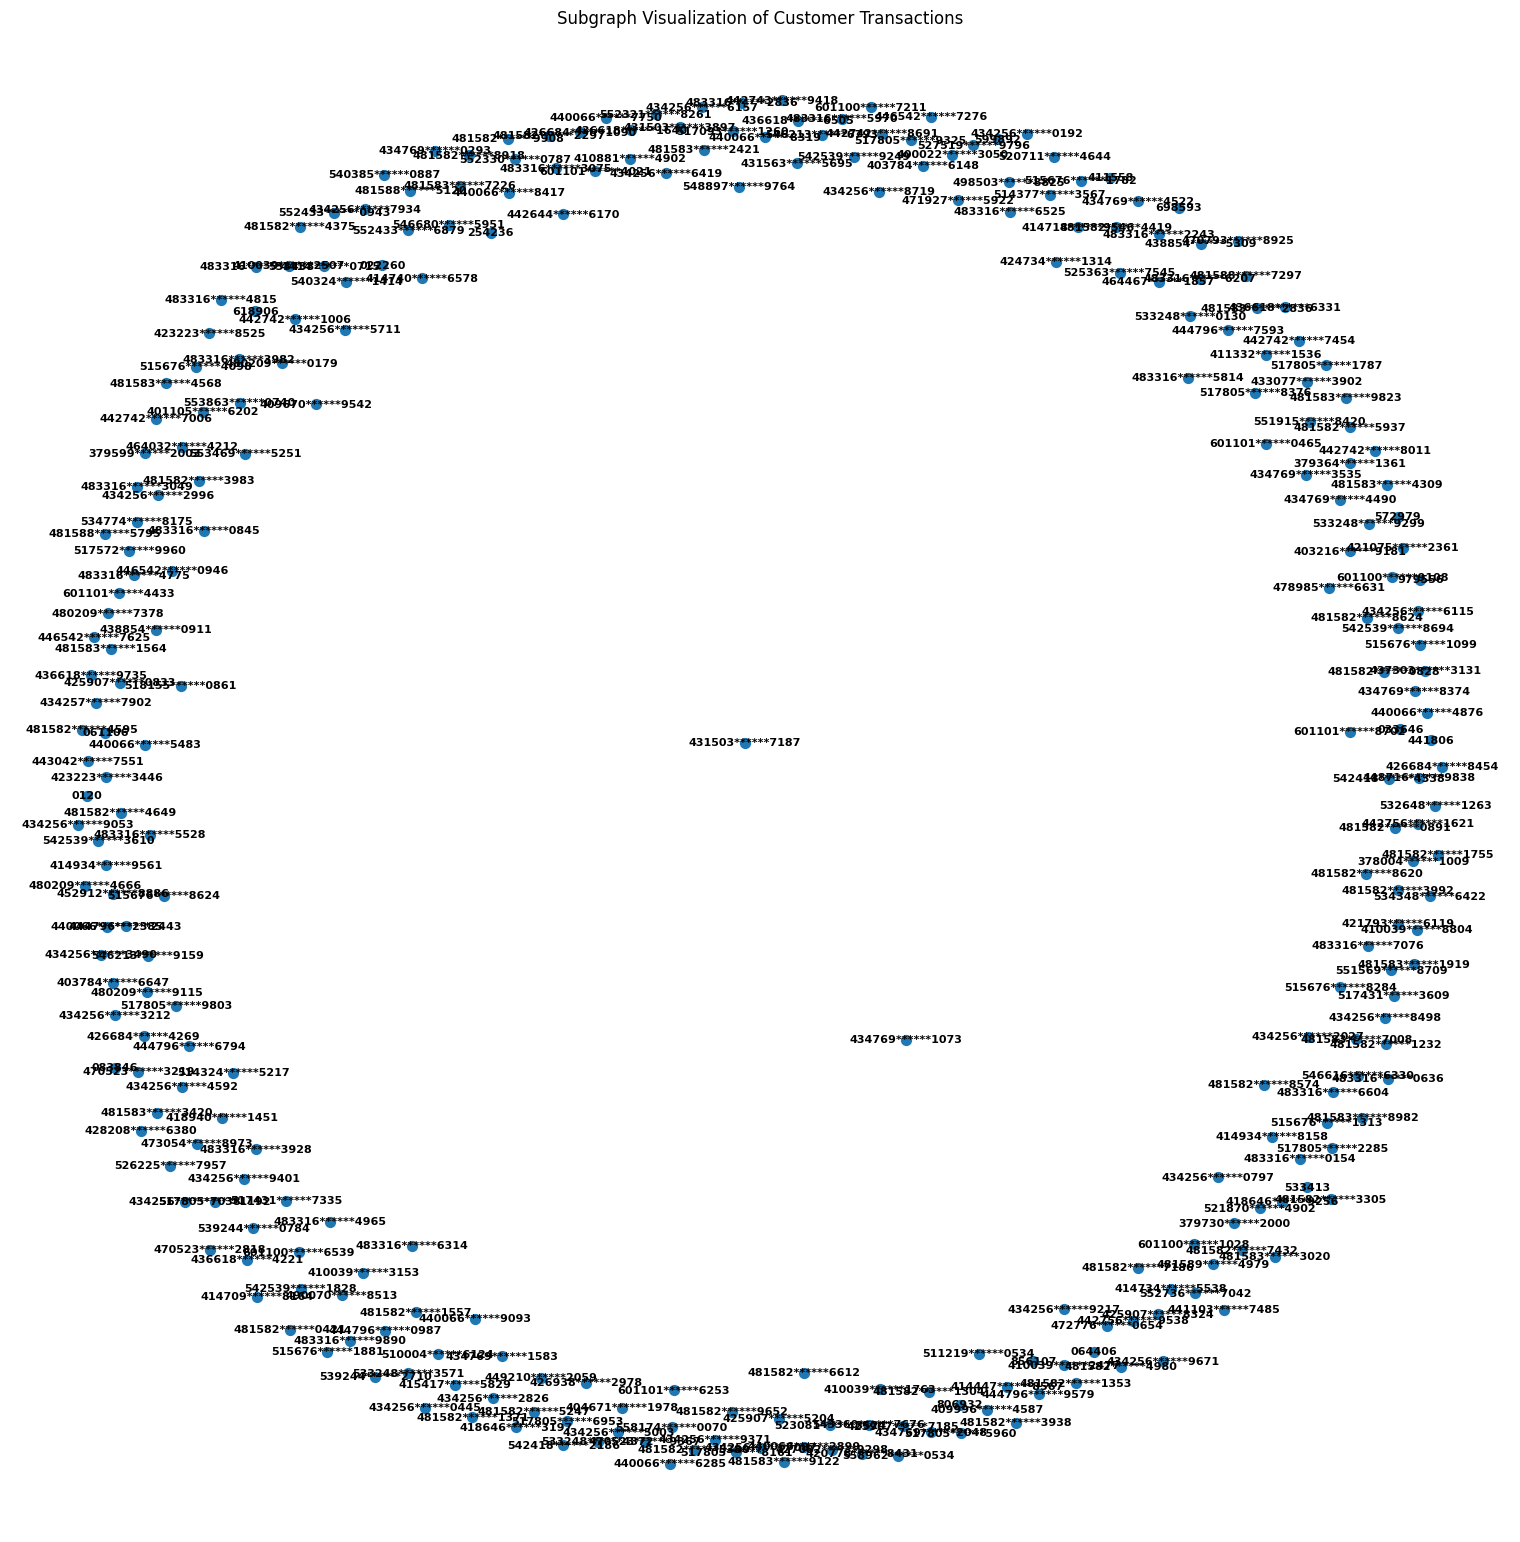

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Build the graph using NetworkX
G = nx.Graph()

# Add nodes
for index, row in nodes.iterrows():
    G.add_node(row['Card_Check_No'], Node_Type=row['Node_Type'])

# Add edges
for index, row in edges.iterrows():
    if row['Edge_Type'] == 'Customer-Transaction_Type':
        G.add_edge(row['Card_Check_No'], row['Trans_Type'], Frequency=row['Frequency'], 
                   Total_Amount=row['Total_Amount'], Average_Amount=row['Average_Amount'], 
                   Edge_Type=row['Edge_Type'])
    
# Visualize the graph
# Create a subgraph with a limited number of nodes
subgraph = G.subgraph(list(G.nodes)[:300])  # Limiting to the first 200 nodes for visualization

# Draw the subgraph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(subgraph, seed=42)  # Position nodes using the spring layout

nx.draw(subgraph, pos, with_labels=True, node_size=50, font_size=8, font_weight='bold')
plt.title("Subgraph Visualization of Customer Transactions")
plt.show()

In [12]:
# Export the graph to GraphML
nx.write_graphml(G, "graph.graphml")



In [13]:
nx.degree_histogram(G)
nx.degree_centrality(G)
degree_dict = dict(nx.degree(G))
max_degree = max(degree_dict.values())

print("The maximum degree is:", max_degree)

max_degree_nodes = [node for node, degree in degree_dict.items() if degree == max_degree]

print("The node(s) with the maximum degree is/are:", max_degree_nodes)

The maximum degree is: 27098
The node(s) with the maximum degree is/are: ['Debit']


In [14]:
# Function to get max degree for each node type
def get_max_degree_by_node_type(G):
    max_degrees = {}
    attributes_by_type = {}
    for node in G.nodes:
        node_type = G.nodes[node].get('Node_Type')
        degree = G.degree[node]
        if node_type:
            if node_type not in max_degrees or degree > max_degrees[node_type]:
                max_degrees[node_type] = degree
                attributes_by_type[node_type] = {
                    'node': node,
                    'degree': degree}
    return max_degrees, attributes_by_type

# Get the max degrees
max_degrees_by_type,attributes_by_type  = get_max_degree_by_node_type(G)

# Print the results
print("Max Degrees by Node Type:", max_degrees_by_type)
print("Attributes by Node Type for Max Degree Nodes:", attributes_by_type)

Max Degrees by Node Type: {'Customer': 2, 'Transaction_Type': 27098}
Attributes by Node Type for Max Degree Nodes: {'Customer': {'node': '434256******9217', 'degree': 2}, 'Transaction_Type': {'node': 'Debit', 'degree': 27098}}


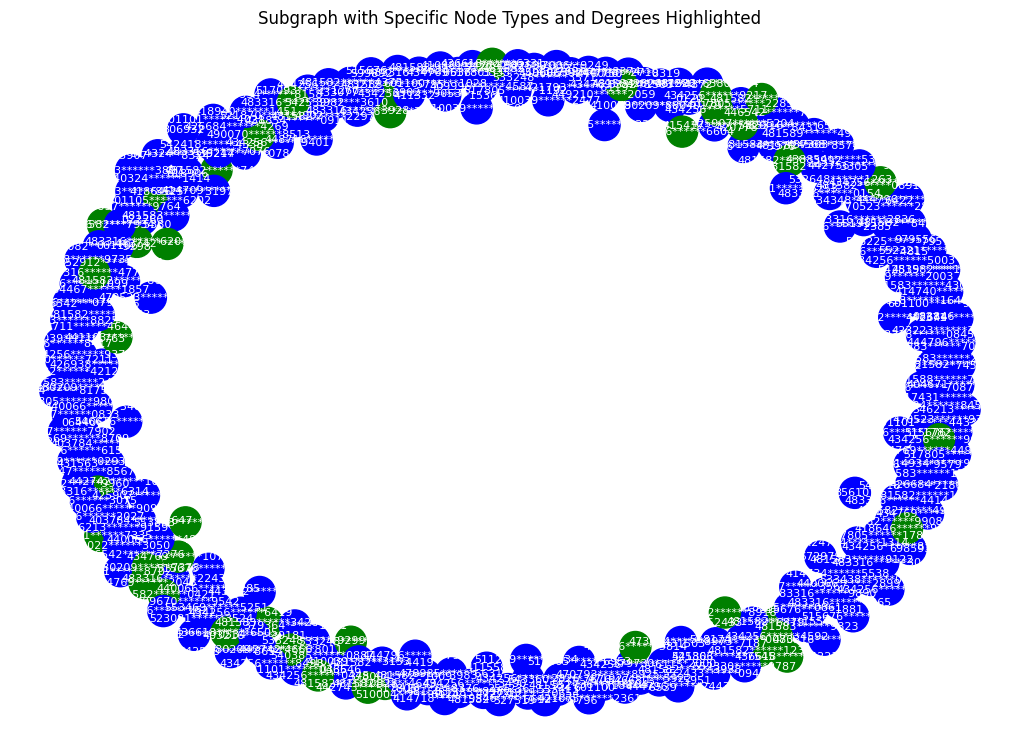

In [15]:
# Draw the subgraph with a layout
pos = nx.spring_layout(subgraph)

# Draw nodes
node_colors = []
for node in subgraph.nodes:
    if G.nodes[node]['Node_Type'] == 'Customer' and G.degree[node] == max_degrees_by_type['Customer']:
        node_colors.append('green')  # Highlight Customer nodes with degree 2 in green
    elif G.nodes[node]['Node_Type'] == 'Transaction_Type' and G.degree[node] == max_degrees_by_type['Transaction_Type']:
        node_colors.append('red')  # Highlight Transaction nodes with max degree in red
    else:
        node_colors.append('blue')

# Draw the subgraph
plt.figure(figsize=(10, 7))
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=8, font_color='white')
plt.title('Subgraph with Specific Node Types and Degrees Highlighted')
plt.show()

In [16]:
pip install node2vec

Note: you may need to restart the kernel to use updated packages.


In [17]:
from node2vec import Node2Vec

# Create a Node2Vec model
# explain the parameters
# dimensions: Dimensionality of the node2vec embeddings
# walk_length: Length of the random walk
# num_walks: Number of random walks to generate
# workers: Number of parallel processes

node2vec = Node2Vec(G, dimensions=2, walk_length=10, num_walks=100, workers=2)  # dimensions=2 for 2D visualization

# Fit the model
# Explain the parameters
# window: Maximum distance between the current and predicted word within a sentence
# min_count: Ignores all words with total frequency lower than this
# batch_words: Target size (in words) for batches of examples passed to worker threads

model = node2vec.fit(window=10, min_count=1, batch_words=4)

embeddings = model.wv

# Print embeddings for each node
for node in G.nodes:
    print(f"Node {node}: {embeddings[str(node)]}")


Computing transition probabilities:  59%|█████▉    | 30560/51368 [53:11<30:51, 11.24it/s]  

In [7]:
G.nodes

NodeView((1, 2, 3, 4, 5, 6))